# Creating Price Impact Curves

Here we create price impact curves and store them in our custom `ExternalMarket` object. At a high level, the external market is a K-Nearest-Neighbors interpolation on quotes from the 1inch API. 

Every hour, we query and store quotes from swapping all permutations of tokens over various randomly distributed trade sizes. We do this using `np.geomspace` for a hard-coded min and max trade size for each token (stored in `config`, and somewhat arbitrary, but reasonable). We randomize the geomspace by scaling each point by a noise component. Let's call each set of API calls a <b>round</b>.

In this script, we pull these quotes from our Postgres database, group them by pair, and then perform a simple KNN regression to create our external market. This external market can then "predict" the price impact of trading a particular pair. These predictions are very good for most trade sizes, but become pretty noisy at the extremes (e.g. swapping 10M USDP in one go). We are working on it.

### KNN Regression Motivation

We could do simpler things like a linear or polynomial regression on our data. This works when the market is liquid enough to handle a given trade (i.e., price impact is roughly linear), but performs really poorly for large trade sizes as price impact quickly (and non-linearly) balloons to 100%. 

To address this problem, we instead interpolate the price impact based on the k nearest trade sizes to the trade size we are trying to test. We specify `k` as `n * k_scale`. Here `n` is the number of rounds contained in the dataset, and `k_scale` is a float, like 3/2. Since in expectation each round of API calls will always hit the same points from the `np.geomspace`, this `k` ensures that we look at neighbors outside the expected points along the `np.geomspace` line.

Really, a KNN regression just allows us to fit the data more precisely than a linear regression by considering clusters of trade sizes. Otherwise, our regression would over-index on the residuals of the really large trades (e.g. swapping 100M USDP).

In [1]:
import logging
from datetime import datetime
from src.sim import Scenario
from src.modules import ExternalMarket
from src.db.datahandler import DataHandler
from src.configs import TOKEN_DTOs, SYMBOL_TO_ADDRESS, ADDRESS_TO_SYMBOL
from src.plotting import plot_price_1inch, plot_regression, plot_predictions

%load_ext autoreload
%autoreload 2

In [2]:
start = int(datetime(2023, 11, 18).timestamp())
with DataHandler() as datahandler:
    quotes = datahandler.get_quotes(start=start, process=True)
print(f"We have {quotes.shape[0]} quotes since {datetime.fromtimestamp(start)}")
quotes.head()

We have 393120 quotes since 2023-11-18 00:00:00


in_amount  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  8.083024e+20   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  2.220498e+21   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  4.953924e+21   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  8.069759e+21   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1.183791e+22   

                                                                                         out_amount  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  2.200640e+16   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  6.066325e+16   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1.353375e+17   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  2.207987e+17   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  3.238885e+17   

                                                                                          price  \
src                                        dst                                                    
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   

                                                                                        timestamp  \
src                                        dst                                                      
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266538   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266539   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266541   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266543   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266544   

                                                                                            hour  \
src                                        dst                                                     
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88 2023-11-18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88 2023-11-18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88 2023-11-18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88 2023-11-18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88 2023-11-18   

                                                                                       reference_price  \
src                                        dst                                                           
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88         0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88         0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88         0.000027   
             

In [4]:
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
prices = scenario.generate_pricepaths("../" + scenario.price_config)
sample = prices[0]
sample.prices  # sample.prices[token1][token2] = price of token1 in token2

[INFO][21:45:28][root]-542832: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][21:45:28][root]-542832: Reading price config from ../src/configs/prices/1h_1696108632_1701289032.json.
[INFO][21:45:28][root]-542832: Fetching wrapped-steth address from Coingecko API.


[INFO][21:45:29][root]-542832: Fetching staked-frax-ether address from Coingecko API.
[INFO][21:45:29][root]-542832: Fetching tbtc address from Coingecko API.
[INFO][21:45:29][root]-542832: Fetching wrapped-steth address from Coingecko API.
[INFO][21:45:29][root]-542832: Fetching staked-frax-ether address from Coingecko API.
[INFO][21:45:29][root]-542832: Fetching tbtc address from Coingecko API.


defaultdict(dict,
            {'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': {'0xdac17f958d2ee523a2206206994597c13d831ec7': 0.999386,
              '0x8e870d67f660d95d5be530380d0ec0bd388289e1': 0.9999849910096148,
              '0x0000000000085d4780b73119b644ae5ecd22b376': 1.0021157633393363,
              '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 0.0004936190179837105,
              '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0': 0.00042976950202115765,
              '0xac3e018457b222d93114458476f3e3416abbe38f': 0.00046331146704990607,
              '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599': 2.6513835460165017e-05,
              '0x18084fba666a33d37592fa2633fd49a74dd93a88': 2.6648872060156793e-05},
             '0xdac17f958d2ee523a2206206994597c13d831ec7': {'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 1.0006143772276177,
              '0x8e870d67f660d95d5be530380d0ec0bd388289e1': 1.0005993590160507,
              '0x0000000000085d4780b73119b644ae5ecd22b376': 1.0027314404437688,


## Fitting Price Impact Curves to Data

Using an illiquid pair as an example. Here we show the expected price impact of swapping WBTC into TUSD using the 1inch router.

In [ ]:
def plot(
    quotes, market, i, j, scale="log", fn_regr=None, fn_pred=None, plot_prices=True
):
    in_token = market.coins[i]
    out_token = market.coins[j]

    quotes_ = quotes.loc[in_token.address, out_token.address]
    if plot_prices:
        _ = plot_price_1inch(quotes_, in_token.symbol, out_token.symbol)
    _ = plot_regression(quotes_, i, j, market, scale=scale, fn=fn_regr)
    _ = plot_predictions(quotes_, i, j, market, scale=scale, fn=fn_pred)

In [ ]:
token1 = TOKEN_DTOs[SYMBOL_TO_ADDRESS["WETH"]]
token2 = TOKEN_DTOs[SYMBOL_TO_ADDRESS["USDC"]]
pair = (token1, token2)

market = ExternalMarket(pair)
market.fit(quotes)
market.update_price(sample.prices)

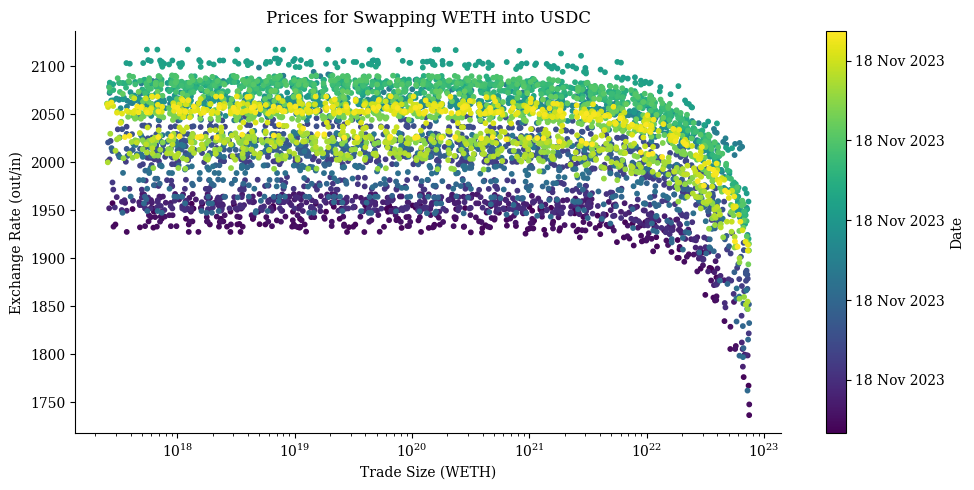

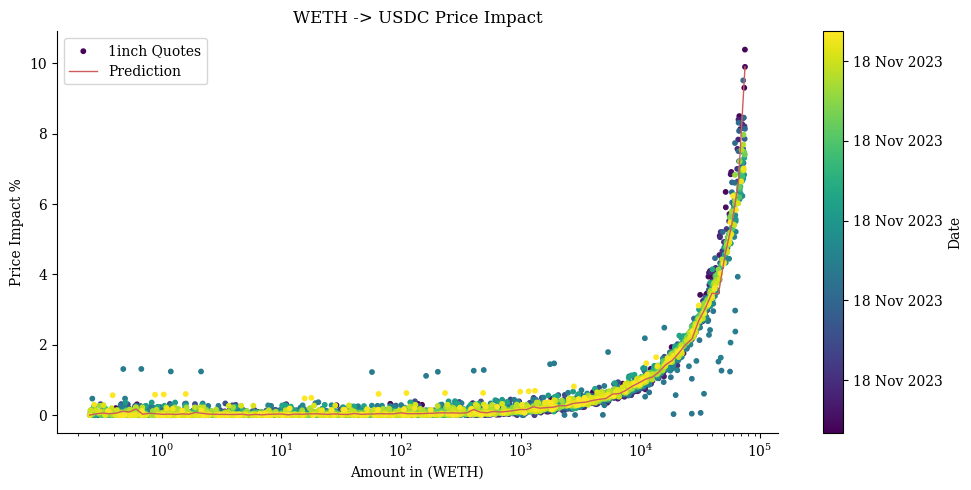

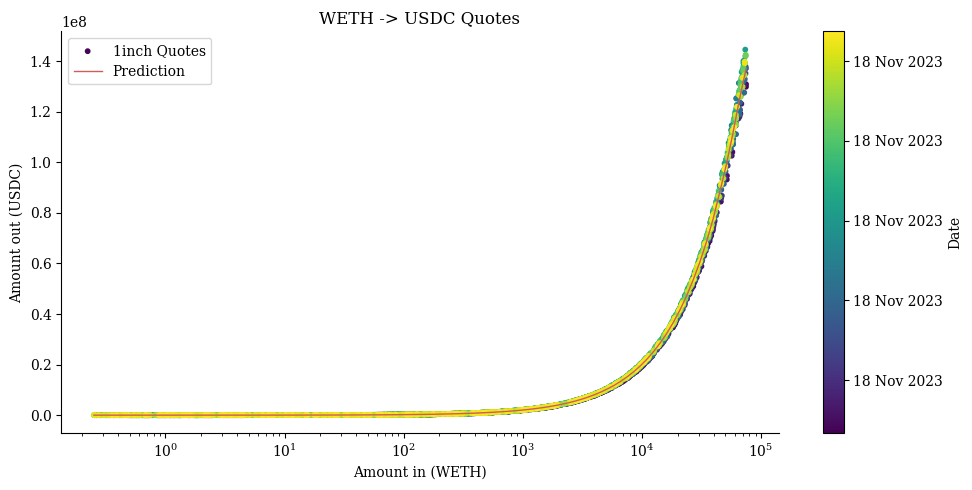

In [ ]:
# token1 -> token2
plot(quotes, market, 0, 1, scale="log")

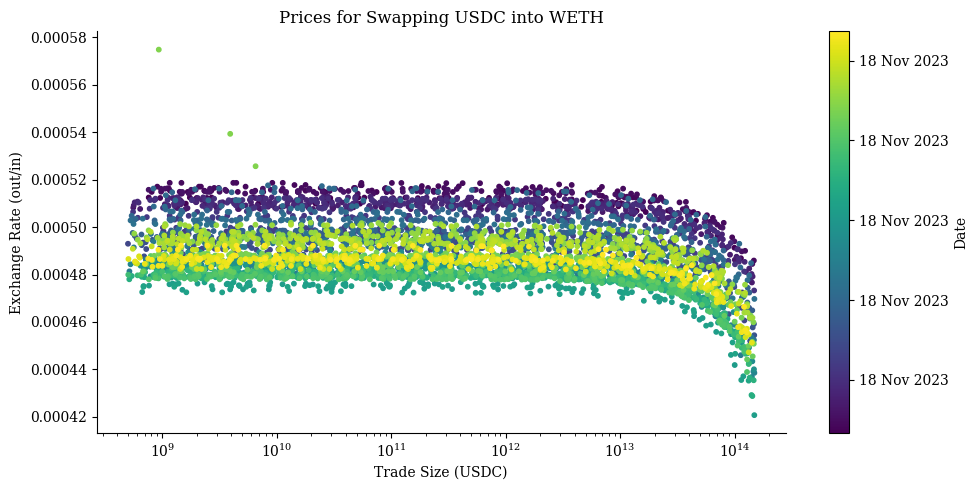

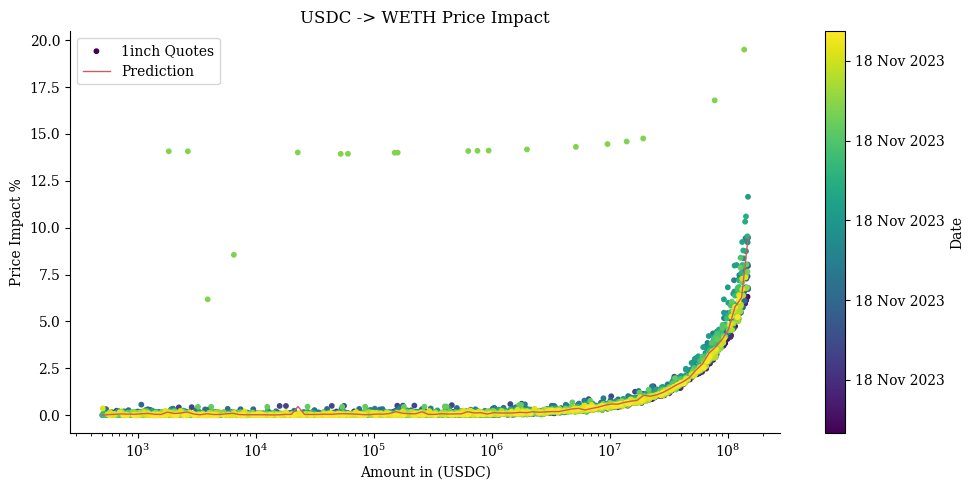

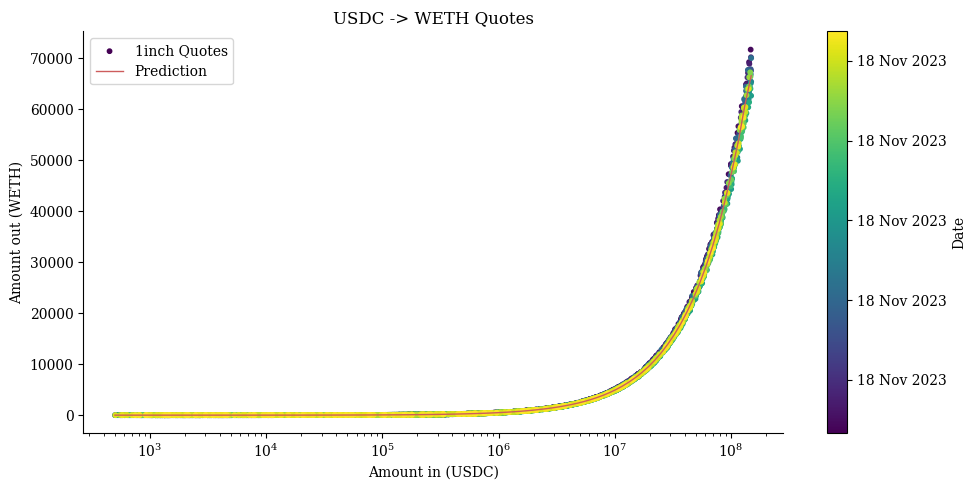

In [ ]:
# token2 -> token1
plot(quotes, market, 1, 0)

## Fitting all Markets

Here we show the logic for fitting the price impact curves for all the markets. This generates the same plots as above for each market in the `figs` directory.

In [31]:
PATH = "../figs/price_impacts"  # change this
fn_regr = f"{PATH}/regressions/" + "{}_{}.png"
fn_pred = f"{PATH}/predictions/" + "{}_{}.png"

# This takes a while to plot
pairs = set([tuple(sorted(pair)) for pair in quotes.index.unique()])
n = len(pairs)
for i, (token1, token2) in enumerate(pairs):
    # Get DTO objects
    token1 = TOKEN_DTOs[token1]
    token2 = TOKEN_DTOs[token2]

    logging.info(f"Fitting ({token1.symbol, token2.symbol}). ({i+1}/{n})")

    market = ExternalMarket((token1, token2))
    market.fit(quotes)
    market.update_price(sample.prices)

    plot(
        quotes,
        market,
        0,
        1,
        scale="log",
        fn_regr=fn_regr.format(token1.symbol, token2.symbol),
        fn_pred=fn_pred.format(token1.symbol, token2.symbol),
        plot_prices=False,
    )
    plot(
        quotes,
        market,
        1,
        0,
        scale="log",
        fn_regr=fn_regr.format(token2.symbol, token1.symbol),
        fn_pred=fn_pred.format(token2.symbol, token1.symbol),
        plot_prices=False,
    )

[INFO][21:27:00][root]-540950: Fitting (('USDP', 'sfrxETH')). (1/36)
[INFO][21:27:05][root]-540950: Fitting (('TUSD', 'sfrxETH')). (2/36)
[INFO][21:29:50][root]-540950: Fitting (('TUSD', 'WETH')). (3/36)
[INFO][21:30:14][root]-540950: Fitting (('TUSD', 'tBTC')). (4/36)
[INFO][21:30:36][root]-540950: Fitting (('USDP', 'WETH')). (5/36)
[INFO][21:34:18][root]-540950: Fitting (('sfrxETH', 'WETH')). (6/36)
[INFO][21:34:23][root]-540950: Fitting (('tBTC', 'sfrxETH')). (7/36)
[INFO][21:34:28][root]-540950: Fitting (('tBTC', 'WETH')). (8/36)
[INFO][21:34:33][root]-540950: Fitting (('WBTC', 'USDP')). (9/36)
[INFO][21:34:38][root]-540950: Fitting (('WBTC', 'USDC')). (10/36)
[INFO][21:34:44][root]-540950: Fitting (('WBTC', 'wstETH')). (11/36)
[INFO][21:34:49][root]-540950: Fitting (('TUSD', 'WBTC')). (12/36)
[INFO][21:34:54][root]-540950: Fitting (('tBTC', 'WBTC')). (13/36)
[INFO][21:35:00][root]-540950: Fitting (('wstETH', 'USDT')). (14/36)
[INFO][21:35:06][root]-540950: Fitting (('USDP', 'USDC'